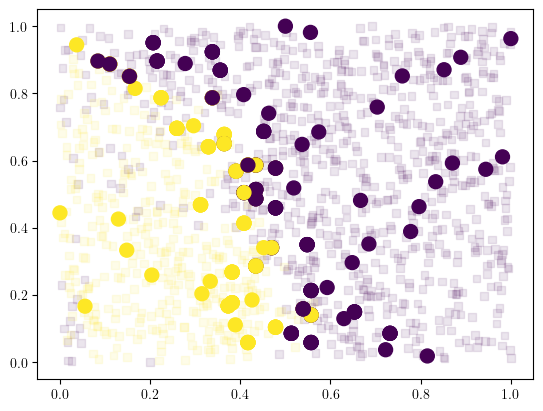

Starting training...
Epoch 100/1000, Loss: 341.2125
  Rho: 1.0343
  LF model lengthscale: 0.3613, outputscale: 0.7128
  Delta model lengthscale: 0.3739, outputscale: 0.6301
Epoch 200/1000, Loss: 303.0688
  Rho: 1.3307
  LF model lengthscale: 0.2657, outputscale: 0.8619
  Delta model lengthscale: 0.3034, outputscale: 0.6877
Epoch 300/1000, Loss: 285.8937
  Rho: 1.4304
  LF model lengthscale: 0.2244, outputscale: 1.0471
  Delta model lengthscale: 0.2925, outputscale: 0.7110
Epoch 400/1000, Loss: 281.1164
  Rho: 1.4329
  LF model lengthscale: 0.2105, outputscale: 1.2384
  Delta model lengthscale: 0.3293, outputscale: 0.6895
Epoch 500/1000, Loss: 278.9023
  Rho: 1.4202
  LF model lengthscale: 0.2065, outputscale: 1.4276
  Delta model lengthscale: 0.3608, outputscale: 0.6511
Epoch 600/1000, Loss: 276.8584
  Rho: 1.4060
  LF model lengthscale: 0.2067, outputscale: 1.6134
  Delta model lengthscale: 0.3801, outputscale: 0.6089
Epoch 700/1000, Loss: 275.5906
  Rho: 1.3914
  LF model lengthscale

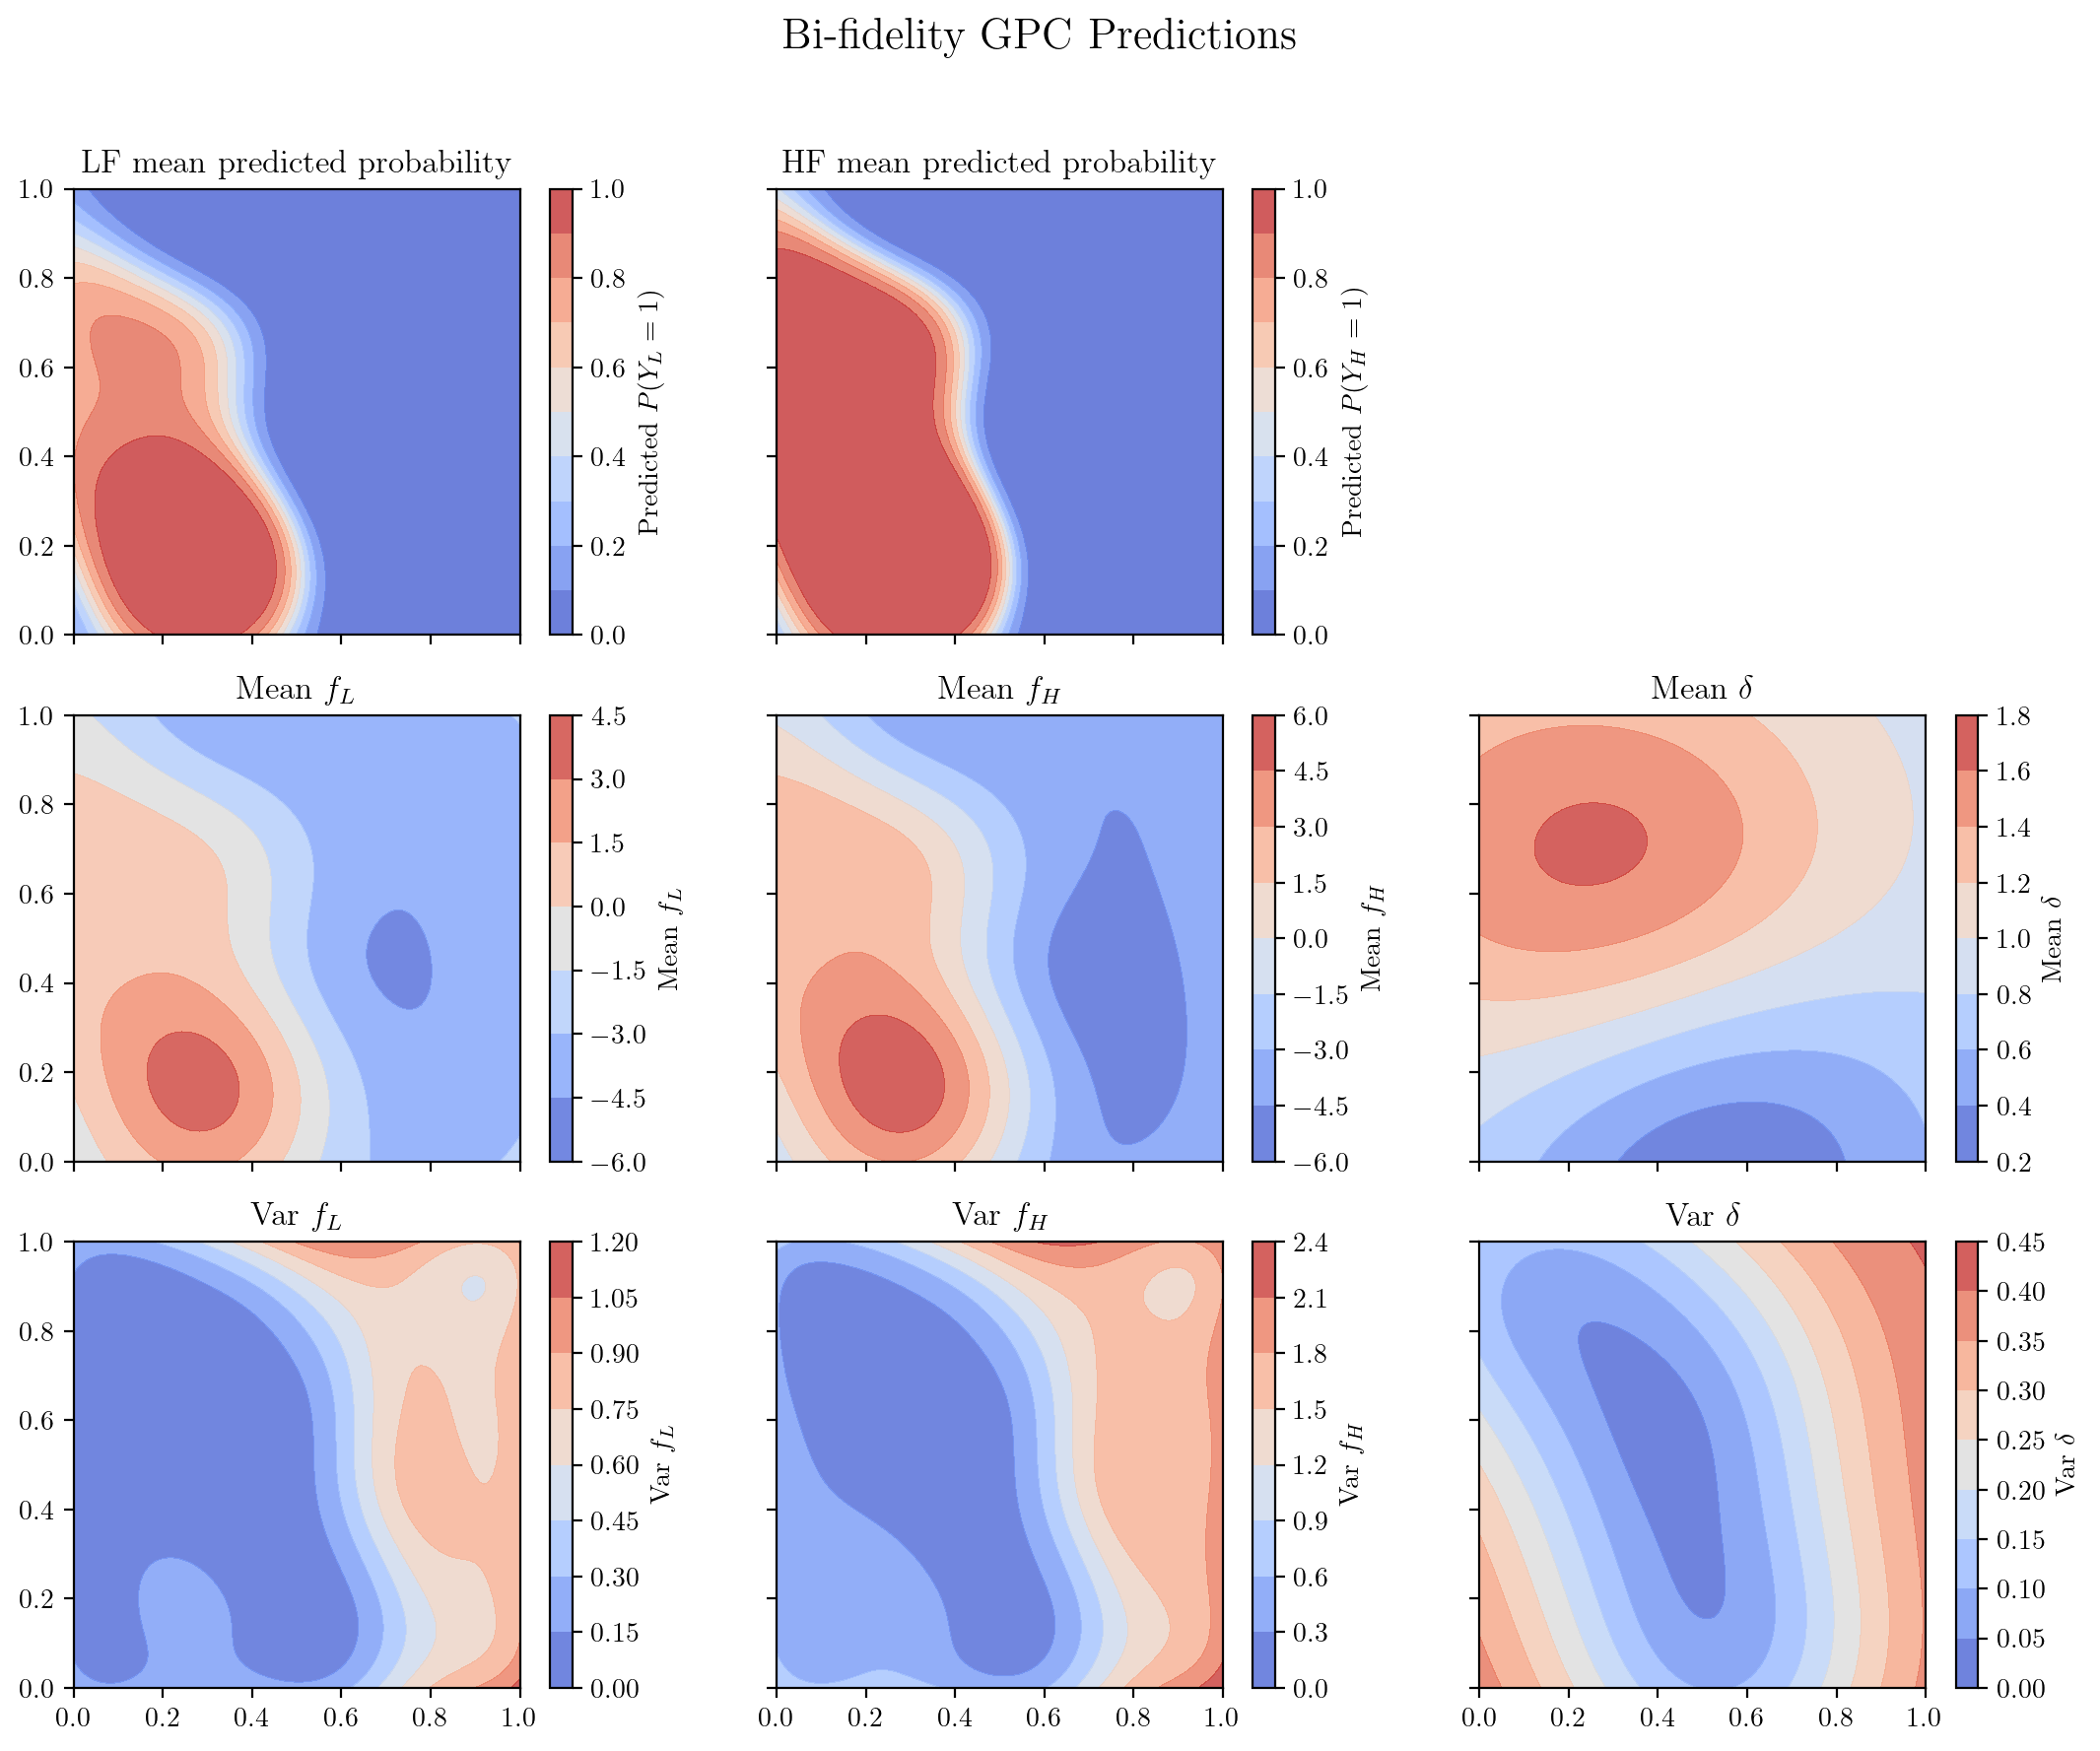

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from src.bfgpc import BFGPC_ELBO
from src.utils_plotting import plot_bfgpc_predictions_two_axes


def load_all_lf_data():
    filepaths = ['01_2M(1).npz', '02_2M(1).npz']
    all_xs = []
    all_ys = []
    for filepath in filepaths:
        data = np.load("./../data/" + filepath)
        x = data["xis"][:, [2, 4]].astype(np.float32)
        y = data["chis"]
        all_xs.append(x)
        all_ys.append(y)

    xs = np.concatenate(all_xs, axis=0)
    ys = np.concatenate(all_ys, axis=0)

    return xs / np.array([[15, 100]]), ys


X_lf, Y_lf = load_all_lf_data()


def load_all_hf_data():
    filepaths = ['01_15M(1).npz', 'test_01_15M.npz', 'test_02_15M.npz']
    all_xs = []
    all_ys = []
    for filepath in filepaths:
        data = np.load("./../data/" + filepath)
        x = data["xis"][:, [2, 4]].astype(np.float32)
        y = data["chis"]
        all_xs.append(x)
        all_ys.append(y)

    xs = np.concatenate(all_xs, axis=0)
    ys = np.concatenate(all_ys, axis=0)

    return xs / np.array([[15, 100]]), ys


X_hf, Y_hf = load_all_hf_data()

# Plot initial training data
plt.figure()
plt.scatter(X_lf[:, 0], X_lf[:, 1], c=Y_lf, cmap='viridis', marker='s', s=30, alpha=0.1)
plt.scatter(X_hf[:, 0], X_hf[:, 1], c=Y_hf, cmap='viridis', marker='o', s=100)
plt.show()
# Create MF classifier instance
# Since data is already normalized, pass identity to denormalize for sampling_func
# Or, better, make sampling_func expect normalized inputs directly
X_lf = torch.from_numpy(X_lf).float()
X_hf = torch.from_numpy(X_hf).float()
Y_lf = torch.from_numpy(Y_lf).float()
Y_hf = torch.from_numpy(Y_hf).float()

model = BFGPC_ELBO(X_lf, X_hf)
model.train_model(X_lf, Y_lf, X_hf, Y_hf, n_epochs=1000)
plot_bfgpc_predictions_two_axes(model)


In [2]:
import gpytorch

model.eval()
grid_res = 100

xi = np.linspace(0, 1, grid_res)
yi = np.linspace(0, 1, grid_res)
xx, yy = np.meshgrid(xi, yi)
grid_points_np = np.vstack([xx.ravel(), yy.ravel()]).T
grid_points_torch = torch.tensor(grid_points_np, dtype=torch.float32)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predicted_probs_hf_grid = model(grid_points_torch)

predicted_probs_hf_grid_reshaped = predicted_probs_hf_grid.cpu().numpy().reshape(grid_res, grid_res)

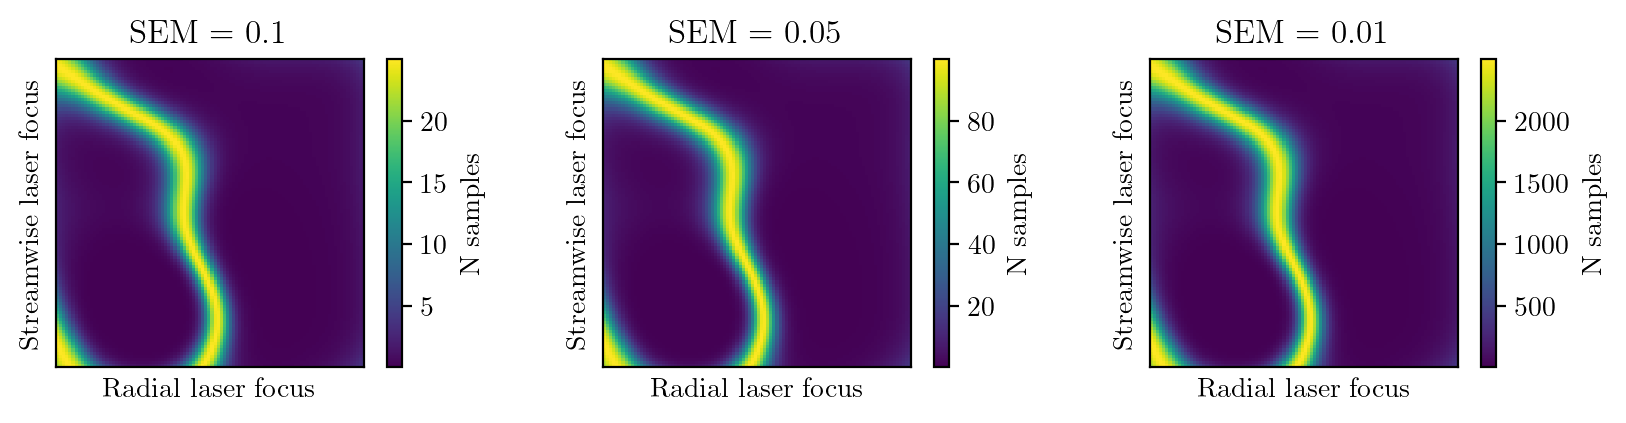

In [43]:
# Now we want to estimate the number of trials required to reach a certain SEM
# SEM = sqrt(p * (1 - p)) / sqrt(N)
# Invert for N given SEM:
# N = (p * (1-p)) / SEM
p_grid_fine = predicted_probs_hf_grid_reshaped

# Plot estimated ns
fig, axs = plt.subplots(1, 3, figsize=(10, 2.0), dpi=200)
SEMs = [0.1, 0.05, 0.01]

for i in range(3):
    ax = axs[i]
    SEM = SEMs[i]

    estimated_ns = (p_grid_fine * (1 - p_grid_fine)) / (SEM**2)


    #im = ax.contourf(xx, yy, estimated_ns, cmap='viridis')
    im = ax.imshow(estimated_ns, cmap='viridis', origin='lower')
    ax.set_aspect('equal')
    fig.colorbar(im, ax=ax, label=f'N samples')
    ax.set_title(f'SEM = {SEM}')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('Radial laser focus')
    ax.set_ylabel('Streamwise laser focus')

plt.show()


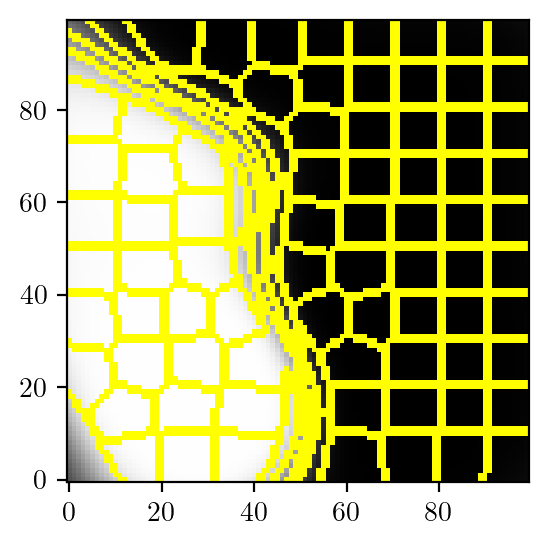

In [27]:
from skimage.segmentation import felzenszwalb, mark_boundaries, slic

#segments = felzenszwalb(p_grid_fine, sigma=2, min_size=10, channel_axis=None)
segments = slic(p_grid_fine, n_segments=100, compactness=0.1, channel_axis=None)

fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200)
ax.imshow(mark_boundaries(p_grid_fine, segments), origin='lower')
ax.set_aspect('equal')
plt.show()

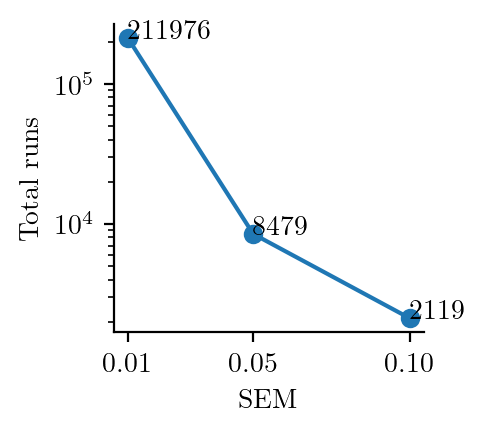

In [42]:
# Give a SEM, and given p_grid and segments, compute the total number of samples needed to uniformly
# achieve a given SEM target across entire domain

p_superpixel_avg = []

for region in segments:
    mask = segments == region
    p_superpixel_avg.append(np.mean(p_grid_fine[mask]))

p_superpixel_avg = np.array(p_superpixel_avg)

ys = []
for SEM in SEMs:
    ns = (p_superpixel_avg * (1.0 - p_superpixel_avg)) / SEM**2
    ys.append(int(ns.sum()))

fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=200)
ax.plot(SEMs, ys, marker='o')
ax.set_yscale('log')
ax.set_xticks(SEMs)
ax.set_xlabel('SEM')
ax.set_ylabel('Total runs')

for SEM, y in zip(SEMs, ys):
    ax.text(SEM, y, f'{y}')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
